In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox

(0) Load

In [2]:
path = '/Users/robertpinochetgomez/GitHub/time-series-analysis/00-data'

df_exports = pd.read_parquet(f'{path}/df_nsc_2025_until_w18.parquet')
df_exports['Week'] = df_exports['Week'].astype('int32')
df_exports.head()

,Country,Volume (KG),Kr/kg,Week,Product,Year,Continent
0,TOTALT,18407,67.23,1,FRESH WHOLE HON,2023,UNCLASSIFIED
1,EU27,13183,64.74,1,FRESH WHOLE HON,2023,EUROPE
2,POLEN,2223,61.44,1,FRESH WHOLE HON,2023,EUROPE
3,FRANKRIKE,2430,66.05,1,FRESH WHOLE HON,2023,EUROPE
4,NEDERLAND,1533,65.60,1,FRESH WHOLE HON,2023,EUROPE


(1) Plot ACF & PACF

- ACF

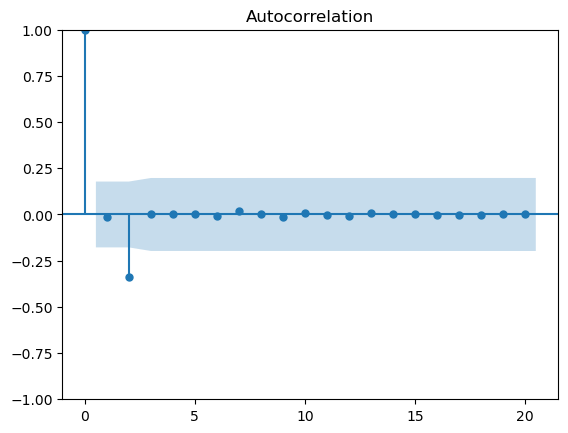

In [3]:
df_totalt = (df_exports.loc[df_exports['Country'].isin(['TOTALT'])]).groupby(by=['Year', 'Week'], as_index=False).agg(
                                                        VolumeKG = ('Volume (KG)', 'sum')
)

df_totalt['Diff.'] = df_exports['Volume (KG)'].diff()

plot_acf(df_totalt['Diff.'].dropna(), lags=20)
plt.show()

Es interesante ver, que en los estadísticos de estacionalidad, la serie dice ser estacionaria a pesar de que ni siquiera esté transformada. Y al ver el gráfico ACF, se demuestra que rasgos de que no es estacionaria, dado que posee el patrón de tener correlaciones de que decrecen lentamente. 
Para el caso del parámetro, este será lag 2. 

- PACF

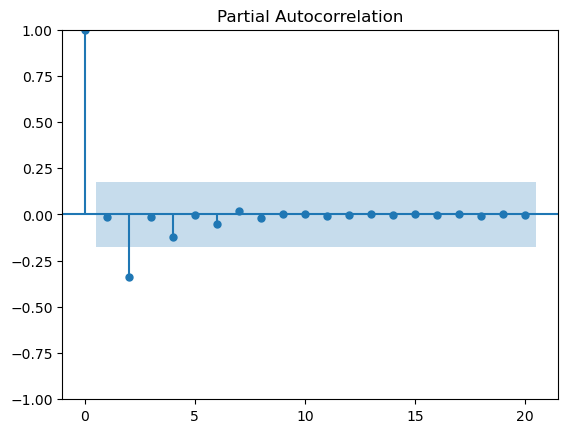

In [4]:
plot_pacf(df_totalt['Diff.'].dropna(), lags=20)
plt.show()

Mismo resultado, se utilizará lag 2. 

(2) Build ARIMA Model

In [5]:
df_exports['Year-Week'] = df_exports['Year'].astype('string') + '-' + df_exports['Week'].astype('string')

df_totalt = (df_exports.loc[df_exports['Country'].isin(['TOTALT'])]).groupby(by=['Year-Week']).agg(
                                                        VolumeKG = ('Volume (KG)', 'sum')
)

df_totalt['Volume_Box_Cox'], lam = boxcox(df_totalt['VolumeKG'])

train = df_totalt.iloc[:-int(len(df_totalt) * 0.2) ]
test = df_totalt.iloc[-int(len(df_totalt) * 0.2):]

# Fit the model (note the lowercase 'model' in the import path)
model = ARIMA(train['Volume_Box_Cox'], order=(2, 1, 2))
model_fit = model.fit()

# Forecast
volume_forecast = model_fit.forecast(steps=len(test))

# Inverse Box-Cox transformation
forecasts = inv_boxcox(volume_forecast, lam)

/Users/robertpinochetgomez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/robertpinochetgomez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/robertpinochetgomez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/robertpinochetgomez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/robertpinochetgomez/opt/anaconda3/lib

In [6]:
# Crear un DataFrame con el resultado de las predicciones
forecasts_df = pd.DataFrame({
    'Forecast': forecasts,
    'Year-Week': test.index  # reutilizamos el índice de test que ya tiene Year-Week
})

forecasts_df = forecasts_df.set_index('Year-Week')

merge_df = df_totalt.merge(forecasts_df, on='Year-Week', how='left')

(3) Results

<Axes: title={'center': 'ARIMA Results'}, xlabel='Year-Week'>

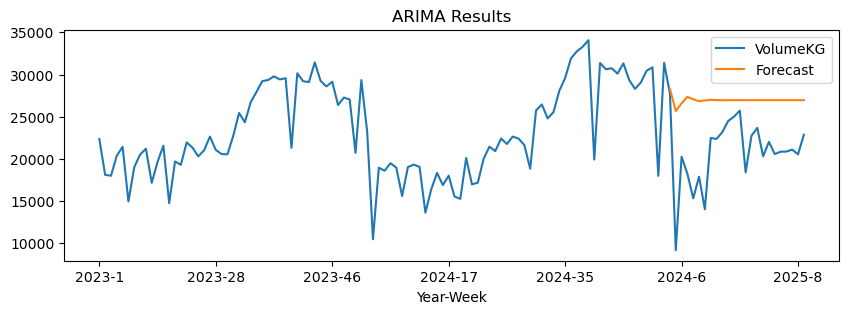

In [7]:
merge_df.drop(columns='Volume_Box_Cox').plot(kind='line', title='ARIMA Results', figsize=(10,3))

Conclusión: Se demuestra que el modelo ARIMA no es capaz de capturar la doble estacionalidad que poseen las exportaciones de noruega a nivel anual. Eso no significa que el modelo sea, malo, solo que no es el indicado para este tipo de series de tiempo. 